In [1]:
from libraries.autodiff import *
import numpy as np
import torch
from scipy.signal import convolve2d

154
[11. 35. 10. 33.]
{0: <autodiff.Var object at 0x0000018B6DC603D0>}
4


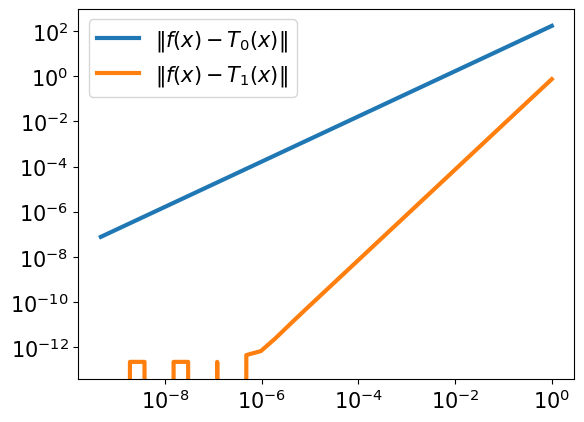

In [3]:
Tape.VARIABLE_INDICES = 0

vars = Tape.Var((2, 2))
vec = Tape.Const(np.array([[1], [2]]))

eqn = (vars @ (vars @ vec) - vec).relu().sum()
print(eqn.forwards([3, 0, 5, 7]))
print(eqn.backwards_from_last_forwards())
print(eqn.input_nodes)
print(eqn.input_parameter_count)
eqn.check([3, 65, 3, 7])

In [4]:
Tape.VARIABLE_INDICES = 0

vars_1 = Tape.Var((2, 4))
vars_2 = Tape.Var((4, 2))
vec = Tape.Const(np.array([[1], [2]]))

eqn = (vars_1 @ (vars_2 @ vec).relu() - vec)
print(eqn.forwards([3, 0, 5, 7, 1, 1, 2, 2, 3, 0, 5, 7, 1, 1, 2, 2]))
print(eqn.backwards_from_last_forwards())
print(eqn.input_nodes)
print(eqn.input_parameter_count)

[65 38]
[ 3. 19.  3.  6.  3. 19.  3.  6.  4.  8.  1.  2.  7. 14.  9. 18.]
{0: <autodiff_fast.Var object at 0x000001E3A5EA6E90>, 8: <autodiff_fast.Var object at 0x000001E394186FD0>}
16


In [5]:


vars = torch.tensor([[3., 0.], [0., 7.]], requires_grad=True)
vec = torch.tensor([[1.], [2.]], requires_grad=True)

eqn = (vars @ (vars @ vec)).square().sum()
print(eqn)
eqn.backward(gradient=torch.tensor(1.))
print(vars.grad)



tensor(9685., grad_fn=<SumBackward0>)
tensor([[ 108.,  360.],
        [1960., 5488.]])


In [118]:
def old_do_convolution(stencil, image):
    assert(stencil.shape[0] % 2 == 1 and stencil.shape[1] % 2 == 1) # must have odd side lengths
    stencil_offset = (-(stencil.shape[0] // 2), -(stencil.shape[1] // 2))

    out_image = np.zeros(image.shape)
    for a in range(image.shape[0]):
        for b in range(image.shape[1]):
            total = 0
            for i in range(stencil.shape[0]):
                for j in range(stencil.shape[1]):
                    x = a + i + stencil_offset[0]
                    y = b + j + stencil_offset[1]
                    if x >= 0 and x < image.shape[0] and y >= 0 and y < image.shape[1]:
                        total += image[x, y] * stencil[i, j]
            out_image[a, b] = total
    
    return out_image

In [7]:
from scipy.signal import convolve2d

stencil = np.array([[1, 1, 1],
                    [1, 0, 1],
                    [1, 1, 1]])

image = np.array([[1, 2, 3, 4, 5],
                  [6, 7, 8, 9, 10],
                  [11, 12, 13, 14, 15],
                  [16, 17, 18, 19, 20],
                  [21, 22, 23, 24, 25]])

expected_result = convolve2d(image, stencil, mode='same')
print(expected_result)

# Call the do_convolution function
result = old_do_convolution(stencil, image)
print(result)

# Check if the result matches the expected result
if np.array_equal(result, expected_result):
    print("Test Passed!")
else:
    print("Test Failed!")

[[ 15  25  30  35  23]
 [ 33  56  64  72  47]
 [ 58  96 104 112  72]
 [ 83 136 144 152  97]
 [ 55  95 100 105  63]]
[[ 15.  25.  30.  35.  23.]
 [ 33.  56.  64.  72.  47.]
 [ 58.  96. 104. 112.  72.]
 [ 83. 136. 144. 152.  97.]
 [ 55.  95. 100. 105.  63.]]
Test Passed!


In [8]:
import scipy.sparse as sp

def flatten_index(i, j, M_shape):
    return i * M_shape[1] + j

def make_convolution_matrix(stencil_shape, image_shape, stencil_vals): # assumes stencil_vals are flattened. returns a sparse matrix
    assert(stencil_shape[0] % 2 == 1 and stencil_shape[1] % 2 == 1) # must have odd side lengths
    stencil_offset = (-(stencil_shape[0] // 2), -(stencil_shape[1] // 2))

    out_matrix_size = image_shape[0] * image_shape[1]
    out_matrix = sp.csr_matrix((out_matrix_size, out_matrix_size), dtype=float)

    for a in range(image_shape[0]):
        for b in range(image_shape[1]):
            for i in range(stencil_shape[0]):
                for j in range(stencil_shape[1]):
                    x = a + i + stencil_offset[0]
                    y = b + j + stencil_offset[1]
                    if x >= 0 and x < image_shape[0] and y >= 0 and y < image_shape[1]:
                        flattened_set_index = flatten_index(a, b, image_shape)
                        flattened_image_index = flatten_index(x, y, image_shape)
                        flattened_stencil_index = flatten_index(i, j, stencil_shape) 
                        
                        out_matrix[flattened_set_index, flattened_image_index] = stencil_vals[flattened_stencil_index]
    
    return out_matrix

In [9]:


stencil = np.array([[1, 1, 1],
                    [1, 0, 1],
                    [1, 1, 1]])

image = np.array([[1, 2, 3, 4, 5],
                  [6, 7, 8, 9, 10],
                  [11, 12, 13, 14, 15],
                  [16, 17, 18, 19, 20],
                  [21, 22, 23, 24, 25]])

expected_result = convolve2d(image, stencil, mode='same')
print(expected_result)

matrix = make_convolution_matrix(stencil.shape, image.shape, stencil.flatten())
result = (matrix @ image.flatten()).reshape(image.shape)
print(result)

# Check if the result matches the expected result
if np.array_equal(result, expected_result):
    print("Test Passed!")
else:
    print("Test Failed!")

[[ 15  25  30  35  23]
 [ 33  56  64  72  47]
 [ 58  96 104 112  72]
 [ 83 136 144 152  97]
 [ 55  95 100 105  63]]
[[ 15.  25.  30.  35.  23.]
 [ 33.  56.  64.  72.  47.]
 [ 58.  96. 104. 112.  72.]
 [ 83. 136. 144. 152.  97.]
 [ 55.  95. 100. 105.  63.]]
Test Passed!


c:\Users\ryan_\OneDrive\Documents\Python\.conda\Lib\site-packages\scipy\sparse\_index.py:108: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])


In [10]:
def make_pooling_matrix(stencil_shape, image_shape, stencil_vals): # assumes stencil_vals are flattened. returns a sparse matrix
    assert(image_shape[0] % stencil_shape[0] == 0 and image_shape[1] % stencil_shape[1] == 0)
    out_shape = (image_shape[0] // stencil_shape[0], image_shape[1] // stencil_shape[1])

    out_matrix_size_rows = out_shape[0] * out_shape[1]
    out_matrix_size_cols = image_shape[0] * image_shape[1]
    out_matrix = sp.csr_matrix((out_matrix_size_rows, out_matrix_size_cols), dtype=float)

    for a in range(0, image_shape[0], stencil_shape[0]):
        for b in range(0, image_shape[1], stencil_shape[1]):
            for i in range(stencil_shape[0]):
                for j in range(stencil_shape[1]):
                    
                    flattened_set_index = flatten_index(a // stencil_shape[0], b // stencil_shape[1], out_shape)
                    flattened_image_index = flatten_index(a + i, b + j, image_shape)
                    flattened_stencil_index = flatten_index(i, j, stencil_shape) 
                    
                    out_matrix[flattened_set_index, flattened_image_index] = stencil_vals[flattened_stencil_index]
    
    return out_matrix

In [11]:
stencil = np.array([[1, 1],
                    [1, 0]])

image = np.array([[1, 1, 2, 2],
                  [1, 1, 2, 2],
                  [2, 2, 1, 1],
                  [2, 2, 1, 1]])

expected_result = np.array([[3, 6],
                            [6, 3]])

matrix = make_pooling_matrix(stencil.shape, image.shape, stencil.flatten())
result = (matrix @ image.flatten()).reshape(expected_result.shape)
print(result)

# Check if the result matches the expected result
if np.array_equal(result, expected_result):
    print("Test Passed!")
else:
    print("Test Failed!")

[[3. 6.]
 [6. 3.]]
Test Passed!


In [27]:
test2 = np.array([[1, 20], [300, 4000]])
test3 = np.array([[[10, 2], [3, 4]], [[5, 6], [7, 8]]])

# identity?
print(np.einsum('ij', test2))

# sum diagonal
print(np.einsum('ii', test2))
print(np.einsum('jj', test2))

# transpose
print(np.einsum('ji', test2))

# sum diagonal 3
print(np.einsum('iii', test3))

# sum diagonal 3
print(np.einsum('iij', test3))

[[   1   20]
 [ 300 4000]]
4001
4001
[[   1  300]
 [  20 4000]]
18
[17 10]


In [95]:
test0 = np.array([[1, 2], [3, 4]])
test1 = np.array([[10, 20], [30, 40]])
a = np.array([1, 2])
b = np.array([10, 20])

# cross product
print(np.einsum('i,i', a, b))

# multiply each val of matrix
print(np.einsum('ij,ij', test0, test1))

# multiply each val of matrix, but the second is transposed
print(np.einsum('ij,ji', test0, test1))

# matrix mult
print(np.einsum('ij,jk', test0, test1))

# element-wise product
print(np.einsum('i,i->i', a, b))

# element-wise product, for matrices
print(np.einsum('ij,ij->ij', test0, test1))

50
300
290
[[ 70 100]
 [150 220]]
[10 40]
[[ 10  40]
 [ 90 160]]


In [62]:
# outer product
print(np.einsum('i,j', a, b))

# sum diagonal
print(np.einsum('ii->i', test0))

# sum rows
print(np.einsum('ij->i', test0))

# sum columns
print(np.einsum('ji->i', test0))

# matrix vector mult
print(np.einsum('ij,j', test0, a))

# scalar multiplication
print(np.einsum(',i', 5, a))

[[10 20]
 [20 40]]
[1 4]
[3 7]
[4 6]
[ 5 11]
[ 5 10]


In [11]:
m1s = np.array([[[1, 0], [0, 1]], [[0, 0], [0, 1]]])
m2 = np.array([[1, 2], [3, 4]])

# multiply each val of each matrix
print(np.einsum('ijk,jk->i', m1s, m2))

# add each vector
print(np.einsum('ijk->jk', m1s))

n1s = np.array([[[[1, 0], [0, 0]], [[0, 2], [0, 0]]], [[[0, 0], [3, 0]], [[0, 0], [0, 4]]]])
n2 = np.array([[1, 10], [100, 1000]])

# multiply each val of each matrix
print(np.einsum('ijkl,kl->ij', n1s, n2))

# add each matrix
print(np.einsum('ijkl->kl', n1s))

# add each matrix times the corresponding element of n2
print(np.einsum('ijkl,ij->kl', n1s, n2))

[5 4]
[[1 0]
 [0 2]]
[[   1   20]
 [ 300 4000]]
[[1 2]
 [3 4]]
[[   1   20]
 [ 300 4000]]


In [3]:
a = np.array([[1, 2], [3, 4]])
b = np.array([[1, 10], [100, 1000]])

# a multiplied copy of a for every element of b (kronecker product!)
print(np.einsum('ij,kl->ijkl', a, b))

[[[[   1   10]
   [ 100 1000]]

  [[   2   20]
   [ 200 2000]]]


 [[[   3   30]
   [ 300 3000]]

  [[   4   40]
   [ 400 4000]]]]


In [36]:
from numpy.lib.stride_tricks import as_strided

def do_convolution(kernel: np.ndarray, stride_x: int, stride_y: int, input: np.ndarray):
    
    input_x = input.shape[0]
    input_y = input.shape[1]

    kernel_x = kernel.shape[0]
    kernel_y = kernel.shape[1]

    output_x = (input_x - (kernel_x - 1)) // stride_x
    output_y = (input_y - (kernel_y - 1)) // stride_y

    new_shape = (output_x, output_y, kernel_x, kernel_y)
    new_strides = (input.strides[0]*stride_x, input.strides[1]*stride_y, input.strides[0]*1, input.strides[1]*1)
    strided = as_strided(input, shape=new_shape, strides=new_strides)

    result = np.einsum('ijkl,kl->ij', strided, kernel)

    return result
    

stencil = np.array([[1, 1, 1],
                    [1, 0, 1],
                    [1, 1, 1]])

image = np.array([[1, 2, 3, 4, 5],
                  [6, 7, 8, 9, 10],
                  [11, 12, 13, 14, 15],
                  [16, 17, 18, 19, 20],
                  [21, 22, 23, 24, 25]])

print(do_convolution(stencil, 1, 1, image))
expected_result = convolve2d(image, stencil, mode='valid')
print(expected_result)

[[ 56  64  72]
 [ 96 104 112]
 [136 144 152]]
[[ 56  64  72]
 [ 96 104 112]
 [136 144 152]]


In [37]:
stencil1 = np.array([[1, 1, 1],
                    [1, 0, 1],
                    [1, 1, 1]])
stencil2 = np.array([[1, 1, 1],
                    [1, 0, 1],
                    [1, 1, 1]])
print(do_convolution(stencil1, 1, 1, stencil2))

[[8]]


In [80]:
# https://chatgpt.com/share/6739afab-b7a4-8001-a559-22f29b6e66e3
# Just wanted to see an example usage of numpy.lib.stride_tricks since documentation is poor

import numpy as np
from numpy.lib.stride_tricks import as_strided

def sliding_window_view(arr, window_size):
    """
    Create a sliding window view of the 1D input array.

    Parameters:
        arr (np.ndarray): Input array.
        window_size (int): Size of the sliding window.

    Returns:
        np.ndarray: 2D array where each row is a sliding window of the original array.
    """
    if window_size > arr.size:
        raise ValueError("Window size must be less than or equal to the size of the array.")

    # Get the shape and strides for the sliding window view
    new_shape = ((arr.size - window_size + 1)//2, window_size)
    new_strides = (arr.strides[0], arr.strides[0]*2)

    # Use as_strided to create the sliding window view
    return as_strided(arr, shape=new_shape, strides=new_strides)

# Example usage
arr = np.arange(10)  # A 1D array
window_size = 4

# Create a sliding window view
windows = sliding_window_view(arr, window_size)

print("Original array:")
print(arr)
print("\nSliding window view:")
print(windows)


Original array:
[0 1 2 3 4 5 6 7 8 9]

Sliding window view:
[[0 2 4 6]
 [1 3 5 7]
 [2 4 6 8]]


In [9]:
import time
import random as rand
from dataclasses import dataclass

@dataclass
class ConvolutionTestConfig:
    trials: int = 100
    image_size: Tuple[int, int] = (100, 100)
    kernel_size: Tuple[int, int] = (5, 5)

def test_convolution_function(f, config: ConvolutionTestConfig, use_torch: bool = False):
    if use_torch:
        for _ in range(config.trials):
            image = torch.rand(config.image_size)
            stencil = torch.rand(config.kernel_size)
            f(image, stencil)
    else:
        for _ in range(config.trials):
            image = np.random.rand(*config.image_size)
            stencil = np.random.rand(*config.kernel_size)
            f(image, stencil)

def time_function(func, **kwargs) -> float:
    start = time.time()
    func(**kwargs)
    end = time.time()
    return end - start

config = ConvolutionTestConfig()

looped_convolution_time = time_function(test_convolution_function, f = lambda image, stencil : old_do_convolution(stencil, image), config=config)
print(looped_convolution_time)
convolution_matrix_time = time_function(test_convolution_function, f = lambda image, stencil : do_convolution(stencil, 1, 1, image), config=config)
print(convolution_matrix_time)
pytorch_time = time_function(test_convolution_function, f = lambda image, stencil : convolve2d(image, stencil, mode='valid'), use_torch=True, config=config)
print(pytorch_time)



NameError: name 'old_do_convolution' is not defined

In [145]:
small_image_dimensions = range(5,125,20)
image_dimensions = range(5,505,20)
config = ConvolutionTestConfig()

results_looped = []
results_custom = []
results_pytorch = []

for image_dimension in small_image_dimensions:
    config.image_size = (image_dimension, image_dimension)
    
    results_looped.append(time_function(test_convolution_function, f = lambda image, stencil : old_do_convolution(stencil, image), config=config))

print("Halfway!")

for image_dimension in image_dimensions:
    config.image_size = (image_dimension, image_dimension)

    results_custom.append(time_function(test_convolution_function, f = lambda image, stencil : do_convolution(stencil, 1, 1, image), config=config))
    results_pytorch.append(time_function(test_convolution_function, f = lambda image, stencil : convolve2d(image, stencil, mode='valid'), use_torch=True, config=config))

Halfway!


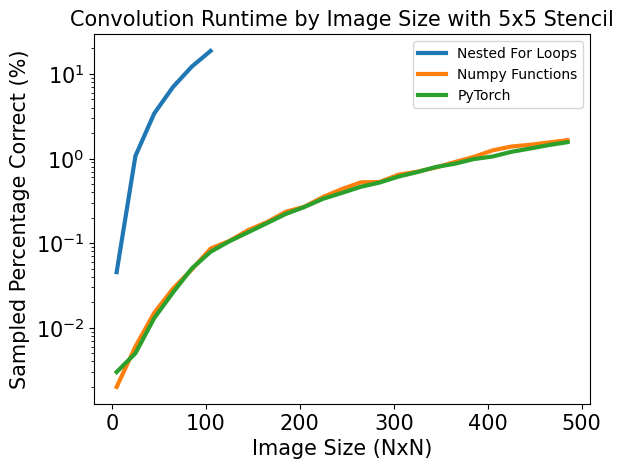

In [148]:
import matplotlib.pyplot as plt

xs_small = list(small_image_dimensions)
xs = list(image_dimensions)

plt.plot(xs_small, results_looped, label="Nested For Loops", linewidth=3)
plt.plot(xs, results_custom, label="Numpy Functions", linewidth=3)
plt.plot(xs, results_pytorch, label="PyTorch", linewidth=3)
plt.xlabel('Image Size (NxN)', fontsize=15)
plt.ylabel('Sampled Percentage Correct (%)', fontsize=15)
plt.title('Convolution Runtime by Image Size with 5x5 Stencil', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.yscale("log")
plt.legend()

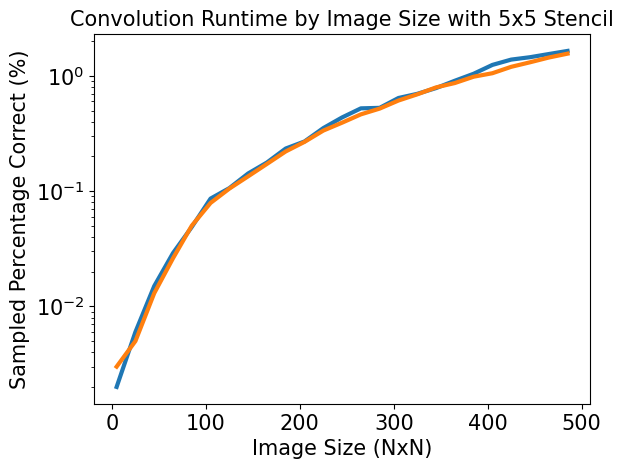

In [147]:
import matplotlib.pyplot as plt

xs = list(image_dimensions)

plt.plot(xs, results_custom, label="Numpy Functions", linewidth=3)
plt.plot(xs, results_pytorch, label="PyTorch", linewidth=3)
plt.xlabel('Image Size (NxN)', fontsize=15)
plt.ylabel('Sampled Percentage Correct (%)', fontsize=15)
plt.title('Convolution Runtime by Image Size with 5x5 Stencil', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.yscale("log")

In [1]:
%load_ext autoreload
%autoreload 2

from autodiff import *
import numpy as np
import torch
from scipy.signal import convolve2d

import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

60
[ 60.  70.  99. 108.]
{0: <autodiff.Var object at 0x000001B0452A2590>}
4


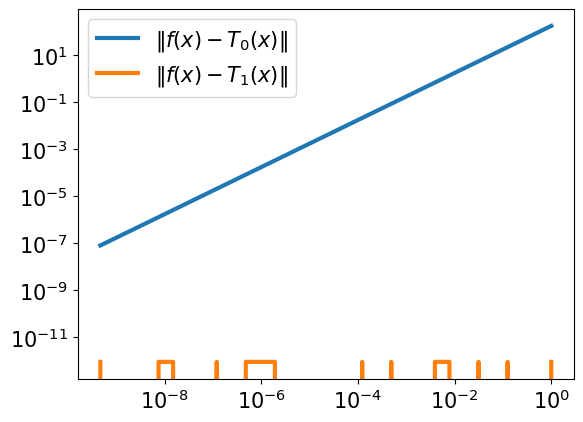

In [2]:
Tape.VARIABLE_INDICES = 0

vars = Tape.Var((2, 2))
#vec = Tape.Const(np.array([[1, 2], [3, 4]]))
vec = Tape.Const(np.array([[1, 2, 3, 5], [6, 7, 8, 9], [10, 11, 12, 13], [14, 15, 16, 17]]))

#print(do_convolution(stencil, 1, 1, stencil))

eqn = (vec.convolve(vars, (1, 1))).sum()
print(eqn.forwards([1, 0, 0, 0]))
print(eqn.backwards_from_last_forwards())
print(eqn.input_nodes)
print(eqn.input_parameter_count)
eqn.check([3, 65, 3, 7])

234
[1. 2. 2. 1. 2. 4. 4. 2. 2. 4. 4. 2. 1. 2. 2. 1.]
{0: <autodiff.Var object at 0x000001B0436B5110>}
16


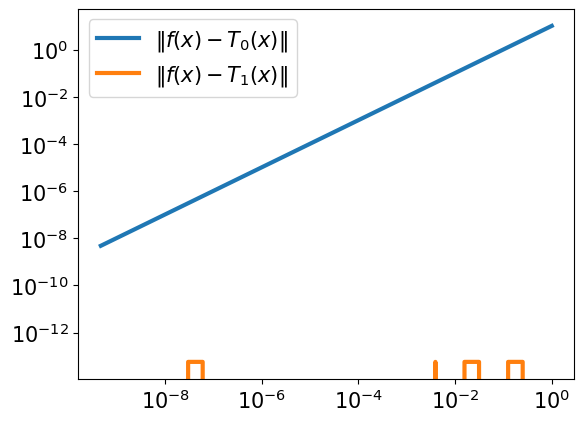

In [3]:
Tape.VARIABLE_INDICES = 0

vec = Tape.Const(np.array([[1, 1, 1], [1, 1, 1], [1, 1, 1]]))
vars = Tape.Var((4, 4))

#print(do_convolution(stencil, 1, 1, stencil))

eqn = (vars.convolve(vec, (1, 1))).sum()
print(eqn.forwards([5, 6, 7, 8, 5, 6, 7, 8, 5, 6, 7, 8, 5, 6, 7, 8]))
print(eqn.backwards_from_last_forwards())
print(eqn.input_nodes)
print(eqn.input_parameter_count)
eqn.check([5, 6, 7, 128, 5, 6, 7, 8, 5, 6, 7, 8, 5, 6, 7, 8])

In [6]:
# tactical reshaping!
arr = np.array([1,2,3,4,5,6,7,8])

print(np.reshape(arr, (-1, 2)).transpose())

arr = np.array([1,2,3,4,5,6,7,8,9])

[[1 3 5 7]
 [2 4 6 8]]
[[1 4 7]
 [2 5 8]
 [3 6 9]]


ValueError: cannot reshape array of size 9 into shape (2)

In [3]:
image = np.array([[1, 2, 3, 4, 5],
                  [6, 7, 8, 9, 10],
                  [11, 12, 13, 14, 15],
                  [16, 17, 18, 19, 20],
                  [21, 22, 23, 24, 25]])
stencil_size = 3

print(image[0::3, 0::3])
print(image[1::3, 0::3])
print(image[2::3, 0::3])
print(image[0::3, 1::3])
print(image[1::3, 1::3])
print(image[2::3, 1::3])
print(image[0::3, 2::3])
print(image[1::3, 2::3])
print(image[2::3, 2::3])

[[ 1  4]
 [16 19]]
[[ 6  9]
 [21 24]]
[[11 14]]
[[ 2  5]
 [17 20]]
[[ 7 10]
 [22 25]]
[[12 15]]
[[ 3]
 [18]]
[[ 8]
 [23]]
[[13]]
